In [2]:
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as tts
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy as dp
import time 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import dataloader as dt
import allmodel as am
from scipy import signal as S
from torcheval.metrics.functional import multiclass_f1_score as f1
import utils
import train


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ws=200
d = dt.Dataloader(ws,1)
d.split(['Person (1)','Person (2)','Person (3)'])
d.load()
d.binary_labels()

In [4]:
Data,DataC,label,_,labelC,_,_,TestData,TestDataC,testlabel,testlabelC,_,_,_ = d.fetch(10,200,Gyro=True)

(2890328, 6)
Filtering Signal
Adding magnitude as feature
Adding filtered Gyro sensor data
Data shape : torch.Size([2890328, 8])
Test Data shape :torch.Size([408364, 8])


In [5]:
yoloLabels = dt.yoloLabeler(label[:int(2890328/4)])

0 0 1.3113021850585938e-06
40003 1000 0.5387708226839701
87175 2000 1.0779167572657267
145076 3000 1.6239962697029113
198829 4000 2.166283138593038
256803 5000 2.7051937023798627
308575 6000 3.2456823428471884
373635 7000 3.787474246819814
444453 8000 4.335604238510132
509738 9000 4.875601931413015
559257 10000 5.414871072769165
612432 11000 5.951562174161276
671279 12000 6.493564613660177
6.9578702569007875


In [6]:
yolotestlabels = dt.yoloLabeler(testlabel[:102091])

0 0 8.362134297688802e-05
44397 1000 0.5381109674771627
94363 2000 1.0760902841885884
1.1411605914433798


In [8]:
ws=200
channel = 8
batch_size=256
model = am.yolo(ws,channel,(1,channel,ws)).cuda()

torch.Size([1, 3136])


In [9]:
#dataset = torch.utils.data.TensorDataset(DataC.float().cuda(), labelC.float().cuda())
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

datasetrelax = torch.utils.data.TensorDataset(DataC[:int(2890328/4)].float().cuda(), torch.tensor(yoloLabels).float().cuda())
dataloaderrelax = torch.utils.data.DataLoader(datasetrelax, batch_size=batch_size, shuffle=True)

In [29]:
model,his = train.trainYolo(model.cuda(),dataloaderrelax,epochs=50,lr=0.001)

Epoch 1/50 - Loss: 0.023600
Epoch 2/50 - Loss: 0.023464
Epoch 3/50 - Loss: 0.023245
Epoch 4/50 - Loss: 0.023088
Epoch 5/50 - Loss: 0.023114
Epoch 6/50 - Loss: 0.022965
Epoch 7/50 - Loss: 0.022773
Epoch 8/50 - Loss: 0.022694
Epoch 9/50 - Loss: 0.022627
Epoch 10/50 - Loss: 0.022482
Epoch 11/50 - Loss: 0.022365
Epoch 12/50 - Loss: 0.022291
Epoch 13/50 - Loss: 0.022191
Epoch 14/50 - Loss: 0.022048
Epoch 15/50 - Loss: 0.021946
Epoch 16/50 - Loss: 0.021891
Epoch 17/50 - Loss: 0.021827
Epoch 18/50 - Loss: 0.021761
Epoch 19/50 - Loss: 0.021682
Epoch 20/50 - Loss: 0.021593
Epoch 21/50 - Loss: 0.021455
Epoch 22/50 - Loss: 0.021440
Epoch 23/50 - Loss: 0.021358
Epoch 24/50 - Loss: 0.021220
Epoch 25/50 - Loss: 0.021062
Epoch 26/50 - Loss: 0.020900
Epoch 27/50 - Loss: 0.020841
Epoch 28/50 - Loss: 0.020756
Epoch 29/50 - Loss: 0.020729
Epoch 30/50 - Loss: 0.020622
Epoch 31/50 - Loss: 0.020622
Epoch 32/50 - Loss: 0.020441
Epoch 33/50 - Loss: 0.020410
Epoch 34/50 - Loss: 0.020313
Epoch 35/50 - Loss: 0.0

In [30]:
g=torch.tensor([0,40,80,120,160,0,40,80,120,160])
predtestlabels = utils.get_yolo_prediction(model,TestData[:102109],channel,ws,ws,g,x_size=39,w_size=53)


In [31]:
P_s_index,P_e_index = utils.indexes(predtestlabels)
T_s_index,T_e_index = utils.indexes(testlabel[:102109])
P_s_index.shape,P_e_index.shape

(torch.Size([2075]), torch.Size([2085]))

In [32]:
mae,percentage,count,hist = utils.avg_distance(T_s_index,P_s_index,15)

In [33]:
hist

tensor([214., 383., 369., 298., 220., 118., 103.,  71.,  48.,  57.,  27.,  35.,
         21.,  20.,  19.])

(tensor(3.4598), 0.9461502125649504, 2003)

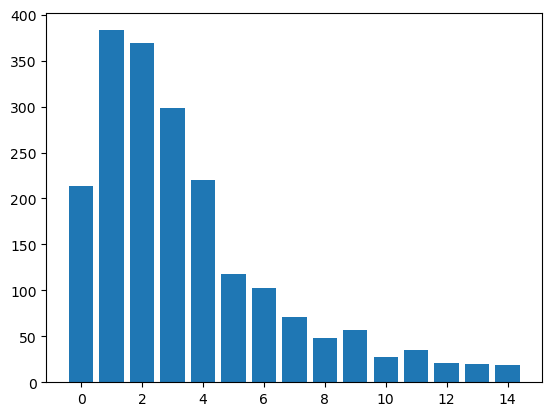

In [34]:
plt.bar(range(15),hist)
mae,percentage,count

In [304]:
here=650
there=here+1
model= model.cpu().eval()
pred = model(TestDataC[here:there])
torch.round(pred.cpu()*torch.tensor([39,53,1]))


tensor([[[ 2., -1.,  0.],
         [16., 24.,  1.],
         [ 1., 22.,  1.],
         [17., 23.,  1.],
         [26., 21.,  1.],
         [ 0.,  0., -0.],
         [-0.,  0., -0.],
         [ 0.,  0., -0.],
         [-0.,  0., -0.],
         [-0.,  1.,  0.]]], grad_fn=<RoundBackward0>)

In [305]:
yolotestlabels[here,:,0]#/[39,58,1],yoloLabels[11512,:,1]/[39,58,1]#.reshape(5,6)

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [12., 22.,  1.],
       [20., 24.,  1.],
       [27., 21.,  1.]])

In [306]:
# start = ((x+G)-w)*c
conf = pred[0,:,2].cpu().detach().numpy()
#conf[conf<0.5]=0
confiscore = dp(conf)
conf = np.round(conf)
#conf[conf>=0.5]=1
x = pred[0,:,0].cpu().detach().numpy()*39
w = pred[0,:,1].cpu().detach().numpy()*53
g = np.array([0,40,80,120,160,0,40,80,120,160])
gt = np.array([[0,40,80,120,160],[0,40,80,120,160]])
startp = np.round(((x+g.T)-w)*conf)
endp = np.round(((x+g.T)+w)*conf)
Tstart = np.round(((yolotestlabels[here,:,:,0]+gt.T)-yolotestlabels[here,:,:,1])*yolotestlabels[here,:,:,2])
Tend = np.round(((yolotestlabels[here,:,:,0]+gt.T)+yolotestlabels[here,:,:,1])*yolotestlabels[here,:,:,2])
#startpall = np.concatenate((startp[:,0],startp[:,1]))#[startp[:,1]>0]))
tstartall = np.concatenate((Tstart[:,0],Tstart[:,1][Tstart[:,1]>0]))
#endpall = np.concatenate((endp[:,0],endp[:,1]))#[endp[:,1]>0]))
tendall = np.concatenate((Tend[:,0],Tend[:,1][Tend[:,1]>0]))
print(tstartall,'\n',tendall)
print(startp,'\n',endp)
confiscore

[  0.   0.  70. 116. 166.] 
 [  0.   0. 114. 164. 208.]
[  0.  32.  59. 114. 165.  -0.  -0.  -0.  -0.   0.] 
 [  0.  81. 103. 161. 208.  -0.  -0.  -0.  -0.   0.]


array([ 3.1353235e-02,  9.2542058e-01,  9.8313558e-01,  9.9527979e-01,
        9.9423862e-01, -1.1711560e-02, -3.6108188e-02, -3.8865709e-04,
       -1.4237720e-03,  3.5173078e-03], dtype=float32)

In [307]:
sortindexes = np.argsort(startp)
sstart = startp[sortindexes]
send = endp[sortindexes]
confsort = confiscore.flatten('F')[sortindexes]

new = []
pre_s = sstart[0]
pred_e = send[0]
for i in range(len(sstart)):
    for j in range(len(sstart)):
        if send[i]>=sstart[j] and sstart[i]<=send[j] and sstart[i]>=send[i] and i!=j:
        #if sstart[i]>=sstart[j] and send[i]<=send[j]:
            new.append([i,j])
tstartall,tendall,sstart*np.round(confsort),send*np.round(confsort),np.round(confsort)

(array([  0.,   0.,  70., 116., 166.]),
 array([  0.,   0., 114., 164., 208.]),
 array([  0.,   0.,   0.,   0.,   0.,   0.,  32.,  59., 114., 165.]),
 array([  0.,   0.,   0.,   0.,   0.,   0.,  81., 103., 161., 208.]),
 array([ 0., -0., -0., -0., -0.,  0.,  1.,  1.,  1.,  1.], dtype=float32))

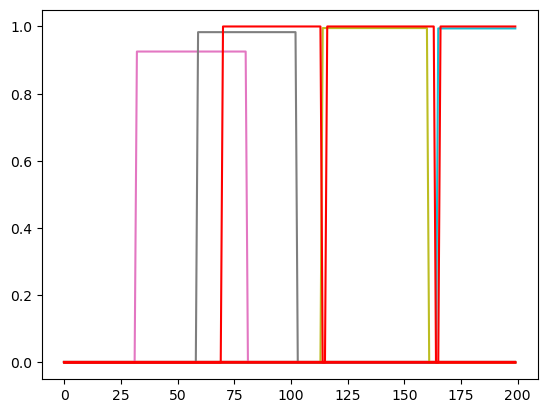

In [308]:
def wave(sstart,send,size=200):
    wave = np.zeros((len(sstart),size))
    for i in range(len(sstart)):
        #print(np.int64(sstart[abs(i)]),np.int64(send[i]))
        wave[i,np.int64(sstart[i]):np.int64(send[i])]=1
    return wave.T
plt.plot(wave(sstart,send)*confsort)
plt.plot(wave(tstartall,tendall),c='red')
plt.show()

In [77]:
wave(sstart,send)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

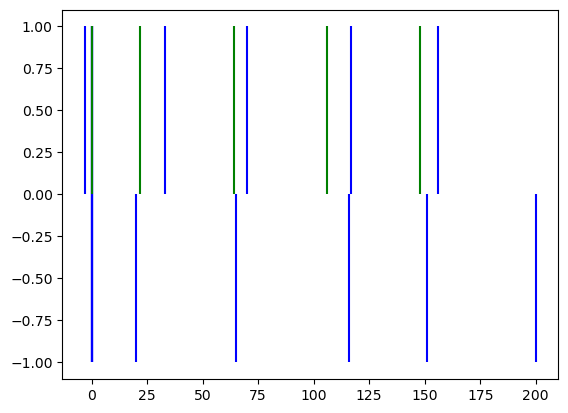

In [319]:

plt.vlines(startp,0,1,color='blue')

plt.vlines(tstartall,0,1,color='green')


plt.vlines(endp,0,-1,color='blue')

plt.vlines(tendall,0,-1,color='purple')

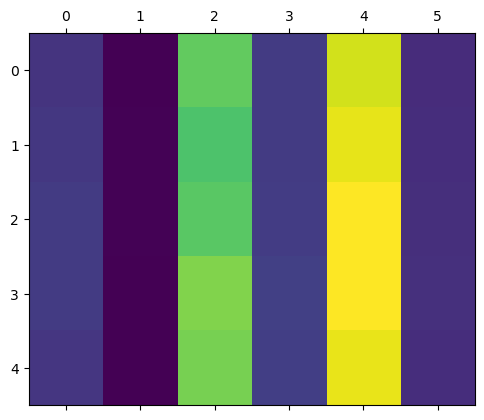

torch.Size([64, 45])

In [391]:
#plt.subplot(1,2,1)
plt.matshow(model(DataC[512:513].cuda()).cpu().detach()[0]*torch.tensor([1,1,39,39,58,58]))
#plt.subplot(1,2,2)
#plt.plot(DataC[512,0],range(200))
plt.show()
model.block2(model.block1(DataC[512:513].cuda())).cpu().detach()[0].shape

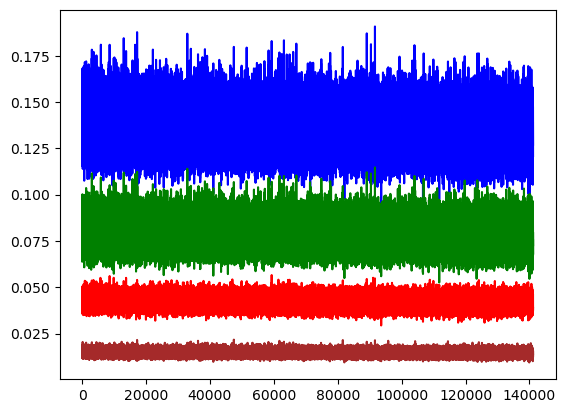

In [282]:
plt.plot(his[0][30:],c='b')
plt.plot(his[1][30:],c='g')
plt.plot(his[2][30:],c='r')
plt.plot(his[3][30:],c='brown')

In [11]:
testpredictionwoc = get_prediction(model.eval().cpu(),TestData,200)
trainpredictionwoc = get_prediction(model.eval().cpu(),Data,200)

In [319]:
print('Test f1 accuracy: ',f1(testlabel[:102091,0].cpu(),predtestlabels[:,0],num_classes=2),
      f1(testlabel[:102091,1].cpu(),predtestlabels[:,1],num_classes=2))



Test f1 accuracy:  tensor(0.9553) tensor(0.9550)


In [14]:
print('train f1 accuracy: ',f1(label[:,0].cpu(),trainpredictionwoc[:,0],num_classes=2),
      f1(label[:,1].cpu(),trainpredictionwoc[:,1],num_classes=2))



train f1 accuracy:  tensor(0.8340) tensor(0.8335)
train f1 accuracy relax:  tensor(0.9501) tensor(0.9496)
